In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import math
import scipy
import copy
import os
import matplotlib.pyplot as plt
from htdeblur import blurkernel
from htdeblur import analysis

# plt.style.use('/home/sarah/.config/matplotlib/deblur.mplstyle')
plt.style.use('deblur')


In [2]:
# figure_directory = '/home/sarah/Dropbox/deblurring/Phase-Deblurring/journalpaper/figures'
# figure_directory = '/media/sarah/dropbox/Dropbox/Dropbox/deblurring/Phase-Deblurring/journalpaper/figures'
# data_directory = '/media/sarah/dropbox/Dropbox/Dropbox/deblurring/Phase-Deblurring/journalpaper/data'

figure_directory = '/Users/zfphil/Dropbox/Berkeley/Phase-Deblurring/journalpaper/figures'
figure_directory = '/Users/zfphil/Dropbox/Berkeley/Phase-Deblurring/journalpaper/figures'
data_directory = '/Users/zfphil/Dropbox/Berkeley/Phase-Deblurring/journalpaper/data'

if not os.path.exists(data_directory):
    os.mkdir(data_directory)

# Mechanical vs. Optical Principles

In [3]:
# Define arguments struct for functions
# TODO is this camera max counts right????
system_params = analysis.getDefaultSystemParams(camera_max_counts=1e8, sample_quantum_yield=0.79)


In [4]:
print(system_params['pulse_count'])
print(system_params['sample_quantum_yield'])
print(system_params['illumination_rep_rate'])

None
0.79
250000.0


## Mechanical Plot Paramters
- Stage Settle Time
- Motion Velocity
- Motion Acceleration

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

viridis = cm.get_cmap('viridis', 10)
newcolors = viridis(np.array([2,7]))
newcmp = ListedColormap(newcolors)

# Additional cmap for invalid values (with black)
newcolors_black = np.insert(newcolors, 0, (0,0,0,1), axis=0)
newcmp_black = ListedColormap(newcolors_black)

common_mech_parameters = {
                     'show_colorbar': False,
                     'show_legend': False,
                     'abbrev_label': 'mechanical',
                     'plot_type': 'regions',
                     'debug': False,
                     'show_labels_y': True,
                     'show_labels_x': False,   
                     'dependent_variable': 'frame_rate',
                     'dependent_variable_sweep': np.arange(1, 15, (15-1)/200),
                     'system_parameters': system_params,
                     'show_hatches': False,
                     'divider_color': 'w'}

mechanical_parameter_list = {'motion_settle_time': {'units': '$s$',
                                                    'parameter_sweep': np.arange(0, 0.25, 0.25 / 200),
                                                    'cmap': newcmp,
                                                    'parameter_is_log_scaled': False,
                                            },
                             'motion_acceleration': {'units': '$mm/s^2$',
                                                     'parameter_sweep': 10 ** np.arange(0, 5, 5 / 200),
                                                     'cmap': newcmp,
                                                     'parameter_is_log_scaled': True
                                                    },
                             'illumination_rep_rate': {'units': '$Hz$',
                                                       'parameter_sweep': 10 ** np.arange(0, 7, 0.05),
                                                       'cmap': newcmp_black,
                                                       'parameter_is_log_scaled': True
                                                    },
                             'motion_velocity': {'units': '$mm/s$',
                                                 'parameter_sweep': np.arange(2,40,(40-2)/200),
                                                 'cmap': newcmp,
                                                 'parameter_is_log_scaled': False,
                                                }}


def plot_mech_analysis(parameter_name, ax):
    return analysis.plotParameterSweep(parameter_name, 
                                    **common_mech_parameters, 
                                    **mechanical_parameter_list[parameter_name],
                                     precomputed = os.path.join(data_directory,'snrs_'+parameter_name+'.npz'),
                                     powerlaw_DNF = os.path.join(data_directory,'dnf_power_law.npz'),
                                     interpolation=None,
                                     ax=ax)


## Illuminance Plots Parameters
- Illumination Power
- Pulse Count
- Camera QE
- Readout noise
- Magnification / NA

In [9]:
viridis = cm.get_cmap('viridis', 256)

system_params['frame_rate'] = 11
common_opt_parameters = {'cmap': viridis,
                     'show_colorbar': False,
                     'show_legend': False,
                     'show_labels_y': True,
                     'show_labels_x': False,   
                     'abbrev_label': 'optical',
                     'debug': False,
                     'show_divider': True,
                     'dependent_variable': 'illuminance',
                     'dependent_variable_sweep':  10 ** np.arange(2, 6, (6-1)/200),
                     'x_is_log_scaled': True,
                     'system_parameters': system_params,
                     'show_hatches': False,
                     'divider_color': 'black',
                     'clim': (2e-2,7e1)}

optical_parameter_list = {'camera_readout_noise': {'units': '$e^-$',
                                                   'parameter_sweep': np.arange(0, 12, 12 / 200),
                                                   'title': None,
                                                   'parameter_is_log_scaled': False,
                                                   'plot_type': 'regions combined',
                                                   'text_list': None, #[('Coded', (200, 10.5)), ('Strobed', (1e4, 0.5))],
                                                  },
#                              'pulse_count': {'units': None,
#                                                      'parameter_sweep': np.arange(5,500,int((500-5)/200)),
#                                                      'title': None,
#                                                      'parameter_is_log_scaled': False,
#                                                      'plot_type': 'regions combined',
#                                                     },
                             'camera_quantum_efficency': {'units': '%',
                                                     'parameter_sweep': np.arange(0.04, 1.0, (1 - .04) / 200),
                                                     'title': None,
                                                     'parameter_is_log_scaled': False,
                                                   'plot_type': 'regions combined',
                                                   'text_list': None, #[('Coded', (200, 0.9)), ('Strobed', (1e4, 0.9))],

                                                         }}

# other_parameters = {'title': None, 'parameter_is_log_scaled': False, 'plot_type': 'regions combined bar',
#                    'text_list': [('Coded', (1.1*1e2, 0.2)), ('Strobed', (5*1e3, 0.2))]}    

other_parameters = {'title': None, 'parameter_is_log_scaled': False, 'plot_type': 'regions combined bar',
                   'text_list': None}    


def plot_opt_analysis(parameter_name, ax):
    return analysis.plotParameterSweep(parameter_name, 
                                       **common_opt_parameters, 
                                       **optical_parameter_list[parameter_name],
                                       precomputed = os.path.join(data_directory,'snrs_'+parameter_name+'.npz'),
                                       powerlaw_DNF = os.path.join(data_directory,'dnf_power_law.npz'),
                                       interpolation=None,
                                       ax=ax)
def plot_paired_analysis(parameter_pair, paired_sweep, ax):
    return analysis.plotParameterSweep(parameter_pair,
                       paired_sweep,
                       **common_opt_parameters,
                       **other_parameters,
                       precomputed = os.path.join(data_directory,'snrs_'+str(parameter_pair)+'.npz'),
                       powerlaw_DNF=os.path.join(data_directory,'dnf_power_law.npz'),
                       ax=ax)

    

## Raw Plots

<IPython.core.display.Javascript object>


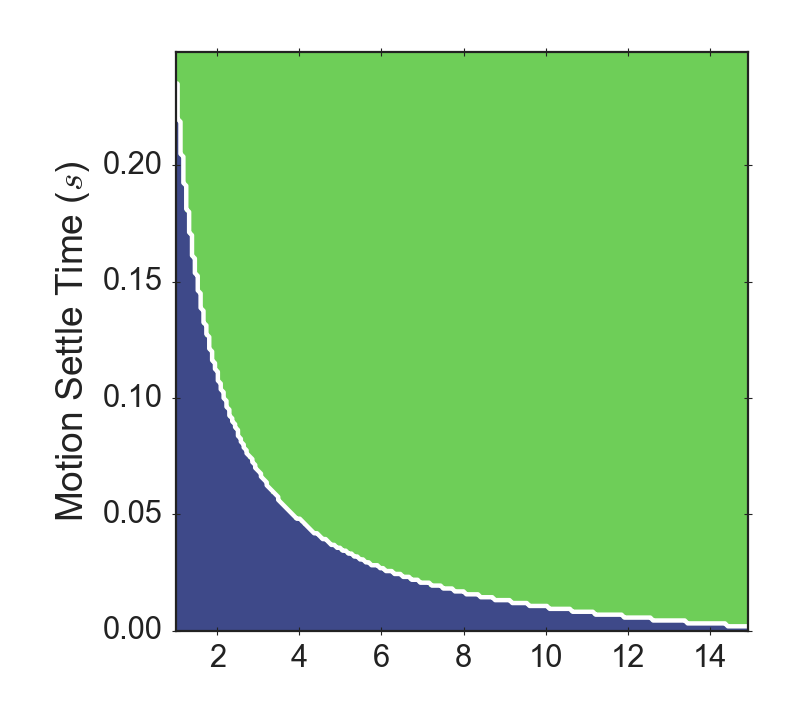

<IPython.core.display.Javascript object>


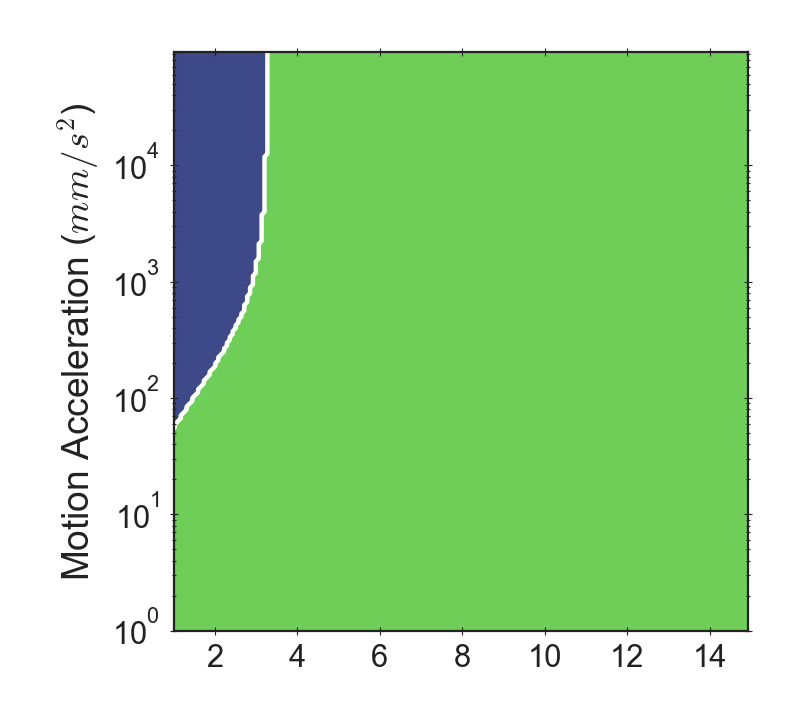

<IPython.core.display.Javascript object>


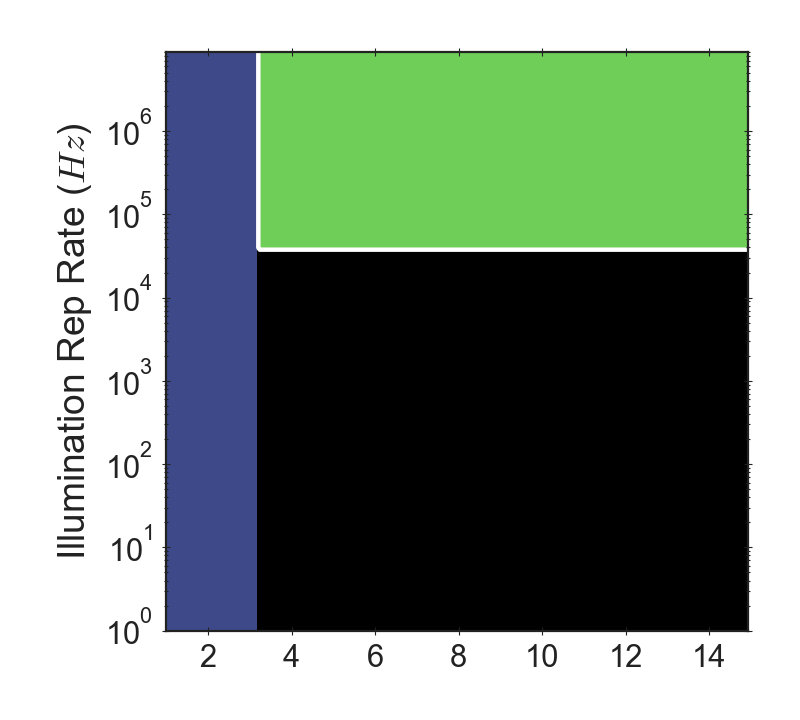

<IPython.core.display.Javascript object>


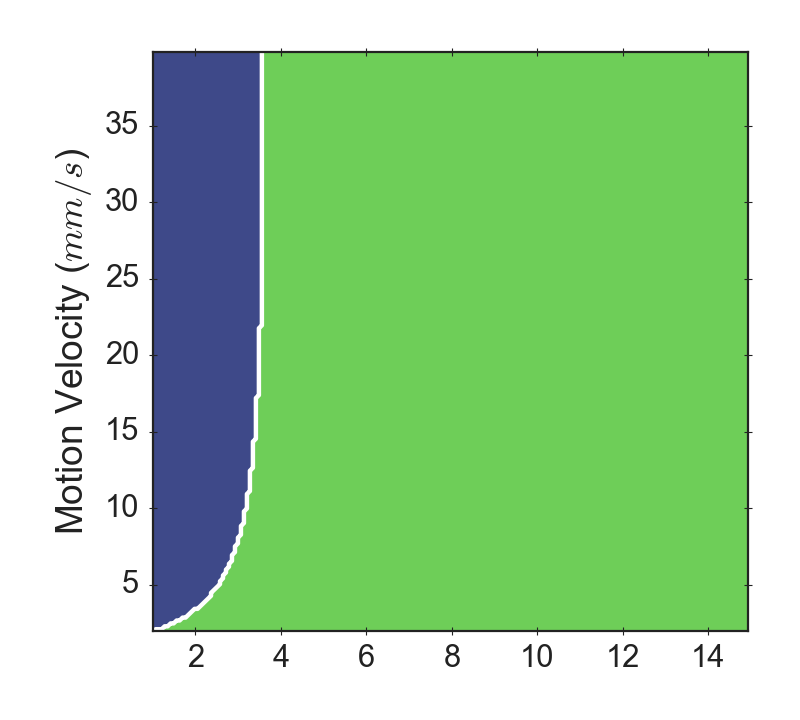

<IPython.core.display.Javascript object>


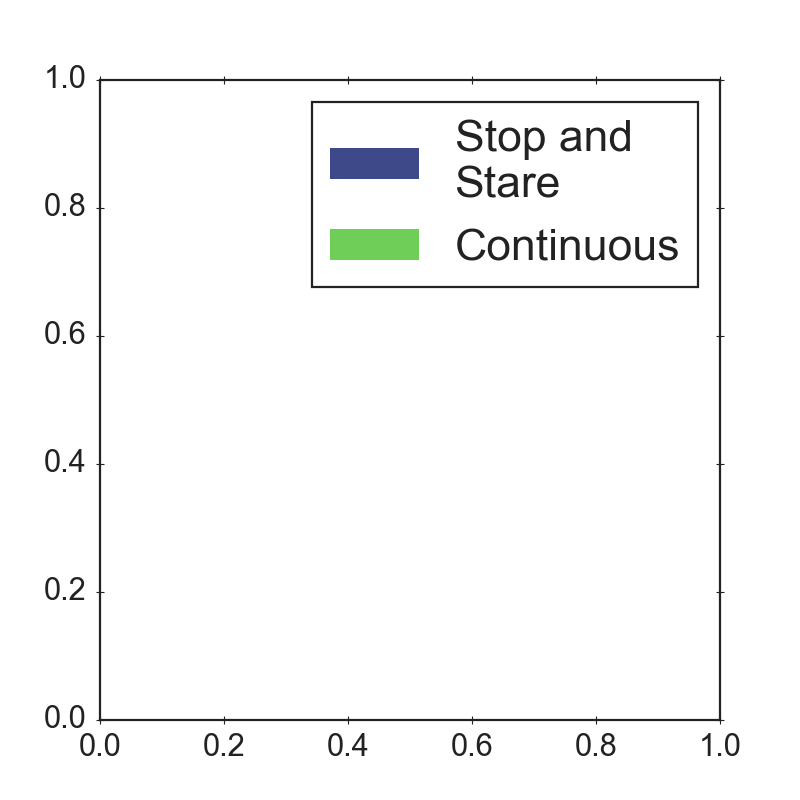

In [10]:
for i,parameter_name in enumerate(mechanical_parameter_list):
    plt.figure(figsize=(5,4.5)); ax = plt.subplot(1,1,1)
    res = plot_mech_analysis(parameter_name, ax)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_directory, 'fig_%s.pdf' % parameter_name), transparent=True)


plt.figure(figsize=(5,5)); ax = plt.subplot(1,1,1)
analysis.add_colors_legend(ax, ('Stop and\nStare', 'Continuous'), 
                           (newcmp(0.),newcmp(1.)), (0.75,0.45))
plt.savefig(os.path.join(figure_directory, 'fig_legend.pdf'), transparent=True)

# plt.savefig(os.path.join(figure_directory, 'mechanical_analysis.pdf'), transparent=True)


In [ ]:

# for i,parameter_name in enumerate(optical_parameter_list):
#     plt.figure(figsize=(5,4.5)); ax = plt.subplot(1,1,1)
#     res = plot_opt_analysis(parameter_name, ax)
#     plt.tight_layout()
#     plt.savefig(os.path.join(figure_directory, 'fig_%s.pdf' % parameter_name), transparent=True)

plt.figure(figsize=(5.5,5)); ax = plt.subplot(1,1,1)
paired_sweep = list(zip(np.array([2, 4, 10, 20, 40, 60]), np.array([0.05, 0.1, 0.25, 0.4, 0.65, 0.8])))
res = plot_paired_analysis(('magnification', 'numerical_aperture'), paired_sweep, ax)
plt.ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(figure_directory, 'fig_mag_na.pdf'), transparent=True)

# plt.figure(figsize=(5,4.5)); ax = plt.subplot(1,1,1)
# plt.colorbar(res[3])
# plt.tight_layout()
# plt.savefig(os.path.join(figure_directory, 'fig_colorbar.pdf'), transparent=True)


# plt.savefig(os.path.join(figure_directory, 'fig_optical_analysis.pdf'), transparent=True)

In [ ]:
plt.gca().xaxis.label.set_color('k')

# Combined Plots

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

num_cols = max(len(mechanical_parameter_list), len(optical_parameter_list) + 1) + 1

plt.figure(figsize=(6*num_cols, 2*5))
for i,parameter_name in enumerate(mechanical_parameter_list):
    ax = plt.subplot(2,num_cols,i+1)
    plot_mech_analysis(parameter_name, ax)
ax = plt.subplot(2,num_cols,num_cols)
analysis.add_colors_legend(ax, ('Stop and\nStare', 'Continuous'), 
                           (newcmp(0.),newcmp(1.)), (0.75,0.45))
plt.tight_layout()

for i,parameter_name in enumerate(optical_parameter_list):
    ax = plt.subplot(2,num_cols,num_cols + i+1)
    plot_opt_analysis(parameter_name, ax)
ax = plt.subplot(2,num_cols,num_cols+i+2)
plot_paired_analysis(('magnification', 'numerical_aperture'), paired_sweep, ax)


ax = plt.subplot(2,num_cols,num_cols + num_cols)
plt.colorbar(res[3])
    
plt.tight_layout()


In [ ]:
plt.savefig(os.path.join(figure_directory, 'fig_system_analysis.pdf'), transparent=True)

In [ ]:
print(os.path.join(figure_directory, 'fig_system_analysis.pdf'))